<a href="https://colab.research.google.com/github/Shaan2522/DL-Models/blob/main/3_PotatoLeaves_Diseases_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Import necessary libraries**

---



In [1]:
import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt
import numpy as np

**Mount google drive**

---



In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


**Data Pre-processing**

---



In [3]:
img_size = 256 # since the image size is 256*256 pixels
batch_size = 32
channels = 3 # rgb
epochs = 30

In [4]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "/content/drive/MyDrive/Colab Notebooks/Datasets/PotatoDiseaseImages",
    shuffle=True,
    image_size=(img_size, img_size),
    batch_size=batch_size
)

Found 2152 files belonging to 3 classes.


In [5]:
class_names = dataset.class_names
class_names

['Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy']

In [6]:
len(dataset) # since the batch size = 32 ->  32*68 = 2176 (last batch is not of full size)

68

In [7]:
for image_batch, label_batch in dataset.take(1):
  print(image_batch.shape)
  print(label_batch.numpy())

(32, 256, 256, 3)
[1 1 0 0 0 0 0 1 0 1 0 2 1 0 0 2 1 2 2 0 1 1 0 1 1 1 0 0 1 1 0 1]


In [8]:
plt.figure(figsize=(10,10))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(image_batch[i].numpy().astype("uint8"))
    plt.xlabel(class_names[label_batch[i]])
plt.show()

**Training / Testing Dataset Split**

---



In [9]:
# 80% training data
# 20% -> 10% validation and 10% testing dataset
train_size = 0.8
len(dataset)*train_size

54.400000000000006

In [10]:
train_ds = dataset.take(54) # training dataset
len(train_ds)

54

In [11]:
test_ds = dataset.skip(54) # testing dataset
len(test_ds)

14

In [12]:
val_size = 0.1
len(dataset)*val_size

6.800000000000001

In [13]:
val_ds = test_ds.take(6) # validation dataset
len(val_ds)

6

In [14]:
test_ds = test_ds.skip(6) # testing dataset
len(test_ds)

8

In [15]:
def get_dataset_partitions_tf(ds, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=10000):
    ds_size = len(ds)

    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=12)

    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)

    train_ds = ds.take(train_size)

    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)

    return train_ds, val_ds, test_ds

In [16]:
train_ds, val_ds, test_ds = get_dataset_partitions_tf(dataset)

In [17]:
len(train_ds), len(val_ds), len(test_ds)

(54, 6, 8)

In [18]:
# for parallely reading and processing
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

In [19]:
# scaling
resize_and_rescale = tf.keras.Sequential([
    layers.experimental.preprocessing.Resizing(img_size, img_size),
    layers.experimental.preprocessing.Rescaling(1.0/255)
])

In [20]:
# data augmentation => images -> horizontal flip, contrast, rotation, zoom
data_augmentaion = tf.keras.Sequential([
    layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
    layers.experimental.preprocessing.RandomRotation(0.2),
    layers.experimental.preprocessing.RandomZoom(0.2)
])

**Model Building**

---



In [21]:
input_shape = (batch_size, img_size, img_size, channels)

model = models.Sequential([
    resize_and_rescale,
    data_augmentaion,
    layers.Conv2D(32, (3,3), activation='relu', input_shape=input_shape),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, (3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, (3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, (3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(3, activation='softmax')
])

model.build(input_shape = input_shape)

In [22]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (32, 256, 256, 3)         0         
                                                                 
 sequential_1 (Sequential)   (32, 256, 256, 3)         0         
                                                                 
 conv2d (Conv2D)             (32, 254, 254, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2  (32, 127, 127, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (32, 125, 125, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (32, 62, 62, 64)          0         
 g2D)                                                 

In [23]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [24]:
history = model.fit(
    train_ds,
    epochs=epochs,
    batch_size=batch_size,
    verbose=1,
    validation_data=val_ds
)

Epoch 1/30
54/54 [==============================] - 36s 576ms/step - loss: 0.8963 - accuracy: 0.5116 - val_loss: 0.7426 - val_accuracy: 0.7135
Epoch 2/30
54/54 [==============================] - 28s 511ms/step - loss: 0.6439 - accuracy: 0.7384 - val_loss: 0.5719 - val_accuracy: 0.7448
Epoch 3/30
54/54 [==============================] - 27s 508ms/step - loss: 0.5695 - accuracy: 0.7581 - val_loss: 0.3488 - val_accuracy: 0.8750
Epoch 4/30
54/54 [==============================] - 27s 504ms/step - loss: 0.4320 - accuracy: 0.8200 - val_loss: 0.3211 - val_accuracy: 0.8438
Epoch 5/30
54/54 [==============================] - 27s 506ms/step - loss: 0.4346 - accuracy: 0.8270 - val_loss: 0.3013 - val_accuracy: 0.8698
Epoch 6/30
54/54 [==============================] - 27s 502ms/step - loss: 0.3516 - accuracy: 0.8582 - val_loss: 0.2486 - val_accuracy: 0.9167
Epoch 7/30
54/54 [==============================] - 27s 505ms/step - loss: 0.2964 - accuracy: 0.8848 - val_loss: 0.3595 - val_accuracy: 0.8438

**Model Validation**

---



In [25]:
scores = model.evaluate(test_ds)

8/8 [==============================] - 4s 97ms/step - loss: 0.2886 - accuracy: 0.9102


In [26]:
scores

[0.28863149881362915, 0.91015625]

In [27]:
history

In [28]:
history.params

{'verbose': 1, 'epochs': 30, 'steps': 54}

In [37]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [38]:
history.history['accuracy']

[0.5115740895271301,
 0.7384259104728699,
 0.7581018805503845,
 0.8200231194496155,
 0.8269675970077515,
 0.8582175970077515,
 0.8848379850387573,
 0.8859953880310059,
 0.8859953880310059,
 0.9033564925193787,
 0.9021990895271301,
 0.9305555820465088,
 0.9432870149612427,
 0.9363425970077515,
 0.9380787014961243,
 0.9305555820465088,
 0.9513888955116272,
 0.9554398059844971,
 0.9571759104728699,
 0.9635416865348816,
 0.9728009104728699,
 0.9710648059844971,
 0.9618055820465088,
 0.9618055820465088,
 0.9728009104728699,
 0.9814814925193787,
 0.9774305820465088,
 0.9849537014961243,
 0.9756944179534912,
 0.9832175970077515]

In [31]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

In [32]:
# accuracy graph
plt.figure(figsize=(8,8))
plt.subplot(1,2,1)
plt.plot(range(epochs), acc, label='Training Accuracy')
plt.plot(range(epochs), val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

# loss graph
plt.subplot(1,2,2)
plt.plot(range(epochs), loss, label='Training Loss')
plt.plot(range(epochs), val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

First image to predict 
Actual label:  Potato___Early_blight
1/1 [==============================] - 0s 256ms/step
Predicted label:  Potato___Early_blight


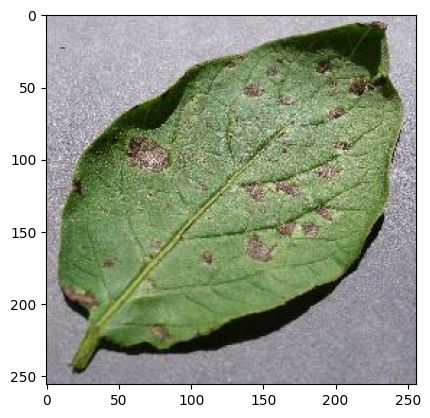

In [33]:
for images_batches, labels_batches in test_ds.take(1):
    first_image = images_batches[0].numpy().astype('uint8')
    first_label = labels_batches[0].numpy()

    print("First image to predict ")
    plt.imshow(first_image)
    print("Actual label: ", class_names[first_label])

    batch_prediction = model.predict(images_batches)
    print("Predicted label: ", class_names[np.argmax(batch_prediction[0])])

In [34]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0) # create a batch

    predictions = model.predict(img_array)

    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence

1/1 [==============================] - 0s 36ms/step


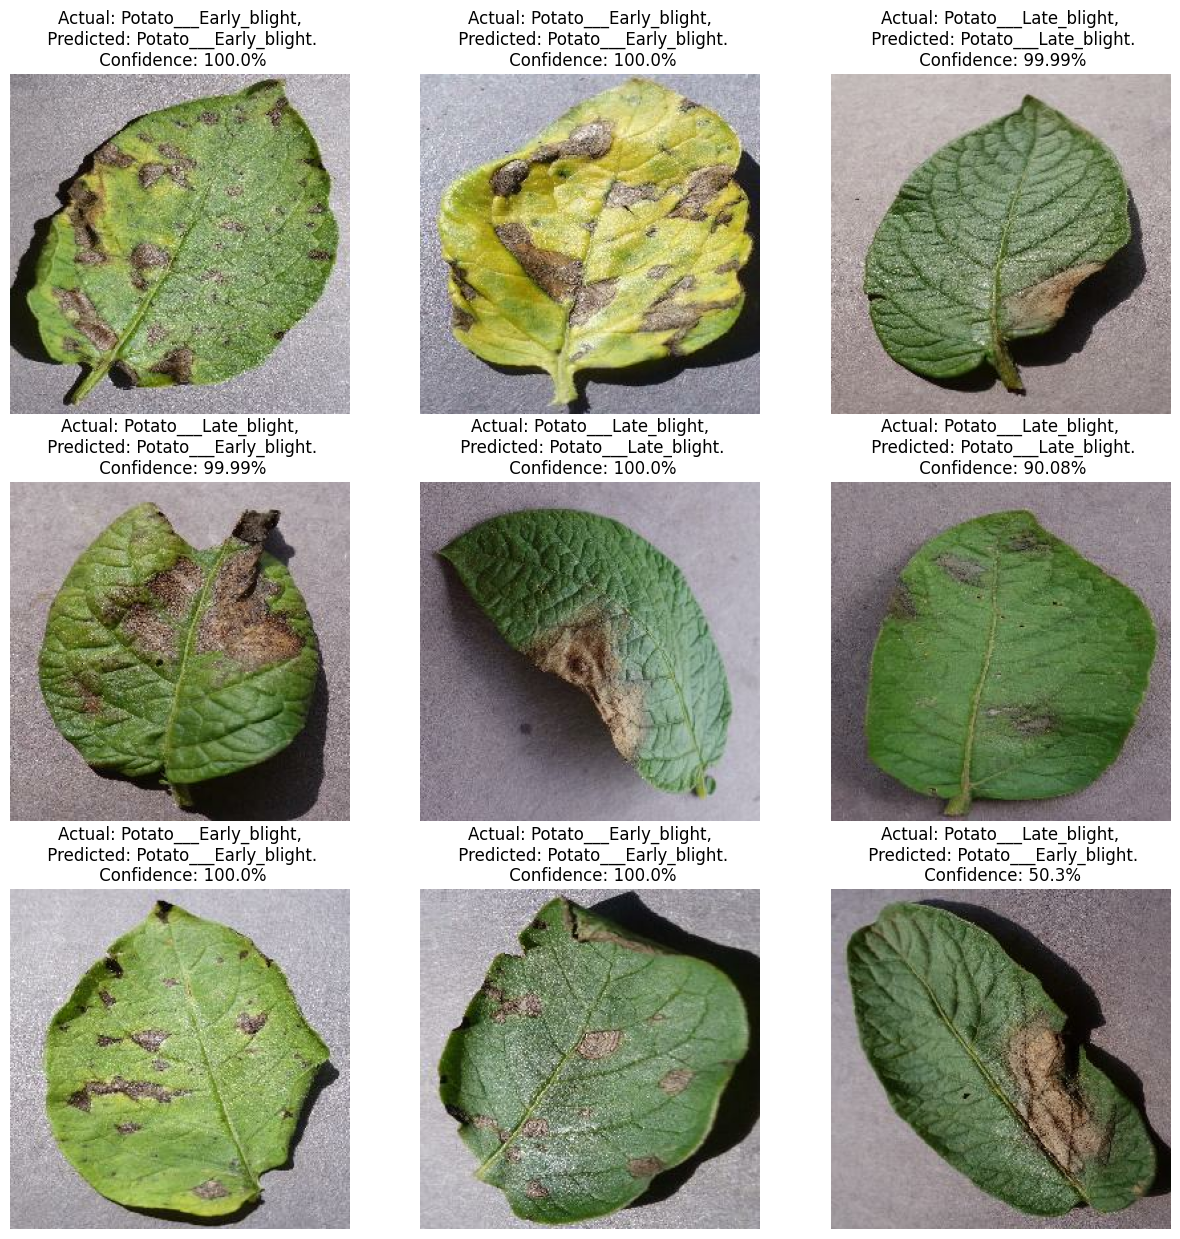

In [35]:
plt.figure(figsize=(15,15))
for images, labels in test_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3,3,i+1)
        plt.imshow(images[i].numpy().astype("uint8"))

        predicted_class, confidence = predict(model, images[i].numpy())
        actual_class = class_names[labels[i]]

        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%")

        plt.axis("off")

**Saving the Model**

---



In [36]:
model_version = 1
model.save(f"/content/drive/MyDrive/Colab Notebooks/Models/{model_version}")